# 同态滤波

In [1]:
#coding:utf-8
%matplotlib inline
import numpy as np
import scipy
from scipy.special import comb
import matplotlib.pyplot as plt
import cv2
from scipy import stats
import scipy.ndimage.filters as nd_filters
import time
from numpy.linalg import cholesky
import scipy.signal as signal

In [2]:
gray = cv2.imread('../../datas/f4.jpg',0)
rgb = cv2.cvtColor(cv2.imread('../../datas/f4.jpg'),cv2.COLOR_BGR2RGB)
rows,cols,ch = rgb.shape

In [3]:
def noise_gaussian(M,N,a = 0,b=1):
    R = a + b * np.random.randn(M,N)
    return R

In [4]:
def noise_pepper(img,a):
    m,n = img.shape[0],img.shape[1]
    R = np.random.randn(m,n)
    dst = np.zeros(img.shape,dtype=np.float64)
    rgb = np.float64(img)
#     df_R = DataFrame(R)
    idx = R <= a
    dst[idx] = rgb[idx]
    return dst

In [5]:
src_noise_pepper = noise_pepper(gray,0.01)
noise = noise_gaussian(rows,cols,a=0,b=0.1)
src_noise_gray = gray.astype(np.float32) + noise * 255
src_noise_gray[src_noise_gray < 0] = 0
src_noise_gray[src_noise_gray > 255] = 255
src_noise_gray = src_noise_gray.astype(np.uint8)

In [9]:
def homo_filter(src,rh,rl,c,D0):
    eps = 1.0e-5
    image_in = src.astype(np.float32)
    m,n = image_in.shape[0],image_in.shape[1]
    P = 2 * m
    Q = 2 * n
    # 取对数
    image1 = np.log(image_in + 1)
    # 对图像填充0,并且乘以(-1)^(x+y) 以移到变换中心 
    fp = np.zeros((P,Q))
    for i in range(m):
        for j in range(n):
            fp[i,j] = image1[i,j] * ((-1) ** (i + 1))
    # 对填充后的图像进行傅里叶变换
    F1 = np.fft.fft2(fp)
    # 生成同态滤波函数，中心在(m+1,n+1)
    homo = np.zeros((P,Q))
    a = D0 ** 2
    r = rh - rl
    for u in range(P):
        for v in range(Q):
            temp = (u - (m + 1.0))**2 + (v - (n+1.0))**2
            homo[u,v] = r * (1 - np.exp((-c) * (temp / a))) + rl
    # 进行滤波
    G = F1 * homo
    # 反傅里叶变换
    gp = np.fft.ifft2(G)
    # 处理得到的图像
    image_out = np.zeros((m,n))
    gp = np.abs(gp)
    g = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            g[i,j] = gp[i,j] * ((-1) ** (i + j))
            
    
    # 指数处理  
    ge = np.exp(g) - 1
    mmax = np.max(ge)
    mmin = np.min(ge)
    rangev = mmax - mmin
    
    for i in range(m):
        for j in range(n):
            image_out[i,j] = 255 * (ge[i,j] - mmin) / rangev
    return image_out

In [10]:
dst = homo_filter(gray,2,0.25,1,80)

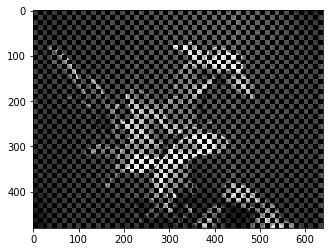

In [15]:
plt.imshow(dst,'gray')

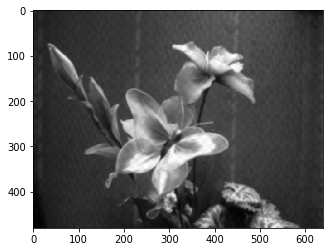

In [14]:
plt.imshow(cv2.GaussianBlur(dst,(5,5),2.4),'gray')

In [19]:
def homofilter(img, gammaH, gammaL):
    grayImg = img
    logImg = np.log(np.int0(grayImg) + 1)
    dctImg = cv2.dct(logImg)
    sz = img.shape

    gH = gammaH / 10
    gL = 1 if gammaL < 1 else 1 / gammaL
    C = 2
    d0 = 500

    H = np.array([[(gH - gL) * (1 - np.exp(-C * (i ** 2 + j ** 2) / d0 ** 2)) + gL for j in range(sz[1])] for i in range(sz[0])])
    totalWeight = sum(H)
    H[0,0] = 1

    HImg = dctImg * H
    idctImg = cv2.idct(HImg)
    dstImg = np.exp(idctImg)
    dstImg[np.where(dstImg > 255)] = 255
    return np.uint8(dstImg)

In [20]:
dst = homofilter(gray,2,0.25)

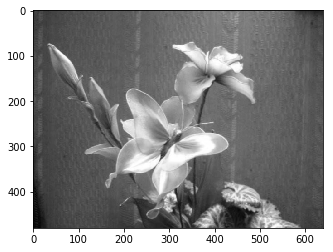

In [21]:
plt.imshow(dst,'gray')

参考：

[1].https://blog.csdn.net/cjsh_123456/article/details/79351654